In [26]:
import torch
import numpy as np
import pickle
from openai import OpenAI
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [27]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [28]:
with open("data/190325_data.pkl", "rb") as f:
    train_chat_data = pickle.load(f)
    
# Remove service chat
del train_chat_data[-1000]

In [29]:
with open("data/100925_data.pkl", "rb") as f:
    chat_data = pickle.load(f)
    
# Remove service chat
del chat_data[-1000]

In [30]:
messages = []
labels = []
game_ids = []
user_ids = []
languages = []
for game_id, game_data in chat_data.items():
    if game_id in train_chat_data.keys():
        continue
    for message in game_data["messages"]:
        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                break
            else:
                continue
        messages.append(message["message"])
        labels.append([int(not message["botID"]), message["botID"]])
        game_ids.append(message["gameID"])
        user_ids.append(message["userID"])
        if game_data["language"] is None:
            languages.append("en")
        else:
            languages.append(game_data["language"])
        
print(len(messages))
print(len(labels))

9631
9631


In [31]:
class NaiveBayesClassifier:
    def __init__(self, path_to_state_dict):
        class MessageClassifier(torch.nn.Module):
            def __init__(self, input_size, hidden_sizes, output_size, dropout=0.75):
                super().__init__()
                self.activation = torch.nn.ReLU()
                layers = []
                current_size = input_size
                for hidden_size in hidden_sizes:
                    layers.append(torch.nn.Linear(current_size, hidden_size))
                    layers.append(torch.nn.BatchNorm1d(hidden_size))
                    layers.append(torch.nn.ReLU())
                    layers.append(torch.nn.Dropout(dropout))
                    current_size = hidden_size
                layers.append(torch.nn.Linear(current_size, output_size))
        
                self.model = torch.nn.Sequential(*layers)
        
            def forward(self, x):
                return self.model(x)

        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.client = OpenAI(
                            api_key="EMPTY",
                            base_url="http://localhost:8000/v1"
                        )
        self.embedding_model = "intfloat/multilingual-e5-large-instruct"

        self.classifier = MessageClassifier(1024, [48, 24], 2, dropout=0.85)
        self.classifier.to(self.device)
        self.classifier.load_state_dict(torch.load(path_to_state_dict, weights_only=True))
        self.classifier.eval()

    def predict(self, message: str):
        # Classifies a message as human (negative score) or bot (positive score).
        embedding = torch.tensor(self.client.embeddings.create(input = [message], model=self.embedding_model).data[0].embedding)
        pred = self.classifier(embedding.unsqueeze(dim=0)).squeeze()
        return (pred[1]-pred[0]).item()
            

In [32]:
classifier = NaiveBayesClassifier("models/run082.pth")

In [33]:
classifier.predict("test")
classifier.predict("bot")
classifier.predict("hi")
classifier.predict("hey guys how are you")

-2.65248703956604

In [34]:
messages_with_i_dont_know= []
user_ids_with_i_dont_know = []
messages_with_idk = []
user_ids_with_idk = []
for message, user_id in zip(messages, user_ids):
    if "i dont know" in message:
        messages_with_i_dont_know.append(message)
        user_ids_with_i_dont_know.append(user_id)
    
    if "idk" in message:
        messages_with_idk.append(message)
        user_ids_with_idk.append(user_id)

In [35]:
for user_id, message in zip(user_ids_with_idk[:3], messages_with_idk[:3]):
    print(message)
    print(classifier.predict(message))
    print("After changing")
    print(message.replace("idk", "i don't know"))
    print(classifier.predict(message.replace("idk", "i don't know")))
    print("-" * 50)

idk, cant just guess
1.6309330463409424
After changing
i don't know, cant just guess
1.3250558376312256
--------------------------------------------------
idk bro
-1.5366469621658325
After changing
i don't know bro
-0.7560179233551025
--------------------------------------------------
idk
-1.837700605392456
After changing
i don't know
-2.0457558631896973
--------------------------------------------------


In [36]:
messages_with_how_about_you= []
user_ids_with_how_about_you = []
messages_with_hbu = []
user_ids_with_hbu = []
messages_with_hi = []

message_with_bot = []
user_ids_with_bot = []
for message, user_id in zip(messages, user_ids):
    if "how about you" in message:
        messages_with_how_about_you.append(message)
        user_ids_with_how_about_you.append(user_id)
    
    if "hbu" in message:
        messages_with_hbu.append(message)
        user_ids_with_hbu.append(user_id)
    if "bot" in message:
        message_with_bot.append(message)
        user_ids_with_bot.append(user_id)
    if "hi" in message:
        messages_with_hi.append(message)

In [37]:
print(classifier.predict("how about you"))
print(classifier.predict("hbu"))

-1.2802646160125732
-3.184713363647461


In [38]:
for user_id, message in zip(user_ids_with_how_about_you[:3], messages_with_how_about_you[:3]):
    print(message)
    print(classifier.predict(message))
    print("After changing")
    print(message.replace("how about you", "hbu"))
    print(classifier.predict(message.replace("how about you", "hbu")))
    print("-" * 50)

how about you, Red?
0.13095107674598694
After changing
hbu, Red?
0.3028487265110016
--------------------------------------------------
I enjoy action movies how about you
4.188089370727539
After changing
I enjoy action movies hbu
1.6950793266296387
--------------------------------------------------
I like espresso mostly, how about you?
2.2999796867370605
After changing
I like espresso mostly, hbu?
2.514404773712158
--------------------------------------------------


In [39]:
for user_id, message in zip(user_ids_with_hbu[:4], messages_with_hbu[:4]):
    print(message)
    print(classifier.predict(message))
    print("After changing")
    print(message.replace("hbu", "how about you"))
    print(classifier.predict(message.replace("hbu", "how about you")))
    print("-" * 50)

red hbu
-2.7308268547058105
After changing
red how about you
-2.0165741443634033
--------------------------------------------------
its lexie ditchburn
-1.5671110153198242
After changing
its lexie ditchow about yourn
-1.7464357614517212
--------------------------------------------------
good hbu
-2.089043140411377
After changing
good how about you
-1.4912000894546509
--------------------------------------------------
hbu?
-1.5022770166397095
After changing
how about you?
-1.3939704895019531
--------------------------------------------------


In [40]:
for user_id, message in zip(user_ids_with_bot[:10], message_with_bot[:10]):
    print(message)
    print(classifier.predict(message))
    #print("After changing")
    #print(message.replace("how about you", "hbu"))
    #print(classifier.predict(message.replace("how about you", "hbu")))

total = 0
for message in message_with_bot:
    total += classifier.predict(message)
print(f"Messages with 'bot' got an average score of {total/len(message_with_bot)}")

Who is the bot?
-3.9564385414123535
Hi Blue. Would you agree that yellow os the bot?
-1.611377239227295
So let's play the game! Who is the bot?
-2.1624462604522705
so you are human or bot
-3.2869205474853516
are you was on human or bot
-3.148477554321289
 i dont mean somthing but there was a same name and same country on chat or bot 
-0.303500771522522
What do you both work? I already told you my work, so please tell me yours.
-1.5244137048721313
ok both of you convince me you are human
-2.441359519958496
na dann bist Du @Purple ein KI Chatbot?
-3.7053639888763428
cool, hey bot, what is your opinion about that
-1.149780035018921
Messages with 'bot' got an average score of -2.151104892840226


In [41]:
random.seed(42)
i = 0
while i < 5:
    idx = random.randint(0, len(messages)-1)
    message = messages[idx]
    user_id = user_ids[idx]
    if user_id != '0':
        continue
    print(message)
    print(classifier.predict(message))
    print("After changing")
    message = message + " bot"
    print(message)
    print(classifier.predict(message))
    print("-" * 50)
    i += 1

yeah im here
-0.3300672769546509
After changing
yeah im here bot
-1.8590456247329712
--------------------------------------------------
fajnie tam
-1.2335546016693115
After changing
fajnie tam bot
-1.6671712398529053
--------------------------------------------------
what do you like to do
-0.1263180673122406
After changing
what do you like to do bot
-1.7560027837753296
--------------------------------------------------
ok, weiter gehts
0.5398737192153931
After changing
ok, weiter gehts bot
-1.7745866775512695
--------------------------------------------------
ach so, dann vergiss es.
-1.5488241910934448
After changing
ach so, dann vergiss es. bot
-1.769914150238037
--------------------------------------------------


In [42]:
print(message_with_bot[9])
print(len(message_with_bot))

cool, hey bot, what is your opinion about that
209


In [43]:
import random, string
random.seed(42)

def add_typo(word):
    """Add a small typo by swapping or deleting one letter."""
    if len(word) < 2:
        return word
    trail = ''
    while word and word[-1] in string.punctuation:
        trail = word[-1] + trail
        word = word[:-1]
    if len(word) < 2:
        return word + trail

    op = random.choice(['swap', 'delete'])
    chars = list(word)
    i = random.randrange(len(chars) - 1)
    if op == 'swap':
        chars[i], chars[i + 1] = chars[i + 1], chars[i]
    else:
        chars.pop(i)
    return ''.join(chars) + trail

def typo_variant(text):
    """Return text with one random word slightly corrupted."""
    words = text.split()
    idx = random.randrange(len(words))
    words[idx] = add_typo(words[idx])
    return ' '.join(words)

n = 0
for idx in range(len(messages)-1, 0, -1):
    if user_ids[idx] == '0':
        msg = messages[idx]
        if len(msg.split()) > 5 or msg.split()[0].lower().strip(",") == "hey" or msg[-1] != "?":
            continue

        typo_msg = typo_variant(msg)
        print(msg)
        print(classifier.predict(msg))
        print("After changing")
        print(typo_msg)
        print(classifier.predict(typo_msg))
        print("-" * 50)

        n += 1
    if n == 4:
        break


what about you?
-1.4504497051239014
After changing
what about oyu?
-2.0356786251068115
--------------------------------------------------
wut r u talkin bout?
1.3139967918395996
After changing
wut r u talkin bout?
1.3139967918395996
--------------------------------------------------
lol wut did i say?
0.682368278503418
After changing
lol uwt did i say?
0.7300033569335938
--------------------------------------------------
lol wut?
0.3462805449962616
After changing
llo wut?
-1.8953317403793335
--------------------------------------------------


In [44]:
random.seed(42)
n = 0
for idx in range(len(messages)-1, 0, -1):
    if user_ids[idx] == '0':
        if len(messages[idx].split(" ")) > 5:
            continue
        if messages[idx].split(" ")[0] == "hey" or messages[idx].split(" ")[0] == "hey,":
            continue
        if messages[idx][-1] != "?":
            continue
        print(messages[idx])
        print(classifier.predict(messages[idx]))
        print("After changing")
        print(f"hi {messages[idx]}")
        print(classifier.predict(f"hi {messages[idx]}"))
        print("-" * 50)
        n += 1
    if n == 4:
        break

what about you?
-1.4504497051239014
After changing
hi what about you?
-1.3991026878356934
--------------------------------------------------
wut r u talkin bout?
1.3139967918395996
After changing
hi wut r u talkin bout?
0.30792704224586487
--------------------------------------------------
lol wut did i say?
0.682368278503418
After changing
hi lol wut did i say?
0.3400662839412689
--------------------------------------------------
lol wut?
0.3462805449962616
After changing
hi lol wut?
-0.34390193223953247
--------------------------------------------------


In [45]:

def analyze_perturbation(orig_scores, after_scores):
    orig_scores = np.array(orig_scores)
    after_scores = np.array(after_scores)

    deltas = after_scores - orig_scores
    mean_delta = np.mean(deltas)
    std_delta = np.std(deltas)

    return mean_delta, std_delta, deltas

def precision_confidence_interval(tp: int, fp: int, confidence: float = 0.95):
    total = tp + fp
    if total == 0:
        return (0.0, 0.0)
    
    p = tp / total
    z = scipy.stats.norm.ppf(1 - (1 - confidence) / 2)
    
    denominator = 1 + z**2 / total
    center = (p + z**2 / (2 * total)) / denominator
    margin = z * np.sqrt(p * (1 - p) / total + z**2 / (4 * total**2)) / denominator
    
    lower = max(0.0, center - margin)
    upper = min(1.0, center + margin)
    
    return (float(lower), float(upper))

In [46]:
before = []
after = []
n = 0
for message in messages_with_idk:
    before.append(classifier.predict(message))
    after.append(classifier.predict(message.replace("idk", "i don't know")))
    n += 1
mean_delta, std_delta, deltas = analyze_perturbation(before, after)
print("Effect of replacing 'idk' with 'i don't know'")
print(f"Mean delta: {mean_delta}")
print(f"Std delta {std_delta}")
print(f"Sample size: {n}")

Effect of replacing 'idk' with 'i don't know'
Mean delta: 0.33703716290302765
Std delta 0.6134400135088173
Sample size: 39


In [47]:
before = []
after = []
n = 0
for message in messages_with_hbu:
    before.append(classifier.predict(message))
    after.append(classifier.predict(message.replace("hbu", "how about you")))
    n += 1
mean_delta, std_delta, deltas = analyze_perturbation(before, after)
print("Effect of replacing 'hbu' with 'how about you'")
print(f"Mean delta: {mean_delta}")
print(f"Std delta {std_delta}")
print(f"Sample size: {n}")

Effect of replacing 'hbu' with 'how about you'
Mean delta: 0.6402702232201894
Std delta 0.8826817166020797
Sample size: 6


In [48]:
before = []
after = []
n = 0
random.seed(42)

for message in random.sample(messages, len(messages)):
    if "bot" in message:
        continue
    before.append(classifier.predict(message))
    after.append(classifier.predict(message + " bot"))
    n += 1
    if n == 200:
        break
mean_delta, std_delta, deltas = analyze_perturbation(before, after)
print("Effect of adding bot")
print(f"Mean delta: {mean_delta}")
print(f"Std delta {std_delta}")
print(f"Sample size: {n}")

Effect of adding bot
Mean delta: -0.8808219350874424
Std delta 0.9443779372360461
Sample size: 200


In [49]:
before = []
after = []
n = 0
random.seed(42)

for message in random.sample(messages, len(messages)):
    if "hi" in message:
        continue
    before.append(classifier.predict(message))
    after.append(classifier.predict("hi " + message))
    n += 1
    if n == 200:
        break
mean_delta, std_delta, deltas = analyze_perturbation(before, after)
print("Effect of adding hi")
print(f"Mean delta: {mean_delta}")
print(f"Std delta {std_delta}")
print(f"Sample size: {n}")

Effect of adding hi
Mean delta: -0.07002246990799904
Std delta 0.6301389150046988
Sample size: 200


In [50]:
random.seed(42)
before = []
after = []
n = 0
for idx in range(len(messages)-1, 0, -1):
    if user_ids[idx] == '0':
        msg = messages[idx]
        typo_msg = typo_variant(msg)
        before.append(classifier.predict(msg))
        after.append(classifier.predict(typo_msg))

        n += 1
        if n == 200:
            break

mean_delta, std_delta, deltas = analyze_perturbation(before, after)
print("Effect of adding a typo")
print(f"Mean delta: {mean_delta}")
print(f"Std delta {std_delta}")
print(f"Sample size: {n}")

Effect of adding a typo
Mean delta: -0.572405967861414
Std delta 0.9490764807429003
Sample size: 200


In [51]:
def get_player_scores(classifier, threshold=1):
    with open("data/190325_data.pkl", "rb") as f:
        chat_data = pickle.load(f)

    with open("data/100925_data.pkl", "rb") as f:
        test_data = pickle.load(f)

    evaluated_ids = []
    player_scores_per_game = []
    for game_id in tqdm(test_data.keys(), desc="Evaluating", total=len(test_data.keys())):
        if game_id in chat_data.keys():
            continue
        game = test_data[game_id]
        evaluated_ids.append(game_id)
        player_scores = defaultdict(float)
        
        for message in game["messages"]:
            if message["userID"] == "GameMaster":
                if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                    break
                else:
                    continue
            else:
                if message["botID"]:
                    player_scores["bot"] += classifier.predict(message["message"])
                else:
                    player_scores[message["userID"]] += classifier.predict(message["message"])        

        if "bot" not in player_scores.keys():
            player_scores["bot"] = 0
        while len(player_scores.keys()) < 3:
            player_scores[f"simulated_player_{3-len(player_scores.keys())}"] = 0
        
        player_scores_per_game.append(player_scores)
    return player_scores_per_game, evaluated_ids

In [52]:
def evaluate_on_old_games(player_scores_per_game, threshold=1):
    overall_TP = 0
    overall_FP = 0
    overall_false_game_ids = []
    overall_FN = 0

    seen_users_TP = 0
    seen_users_FP = 0
    seen_users_false_game_ids = []
    seen_users_FN = 0
    
    new_users_TP = 0
    new_users_FP = 0
    new_users_false_game_ids = []
    new_users_FN = 0


    with open("data/corresponding_game_ids.pkl", "rb") as f:
        game_ids = pickle.load(f)
    
    with open("data/users_in_train.pkl", "rb") as f:
        train_users = pickle.load(f)
        
    with open("data/users_in_val.pkl", "rb") as f:
        val_users = pickle.load(f)

    seen_users = train_users | val_users

    for game_scores, game_id in zip(player_scores_per_game, game_ids):

        colors = list(game_scores.keys())
        for player in colors:
            if player == "bot":
                continue

            bot_score = game_scores["bot"]
            human_score = game_scores[player]

            if bot_score - human_score > threshold:
                # Classifier would accuse the bot
                overall_TP += 1
                if player in seen_users:
                    seen_users_TP += 1
                else:
                    new_users_TP += 1
            elif human_score - bot_score > threshold:
                # Classifier would accuse a human
                overall_FP += 1
                if player in seen_users:
                    seen_users_FP += 1
                    seen_users_false_game_ids.append(game_id)
                else:
                    new_users_FP += 1
                    new_users_false_game_ids.append(game_id)
                overall_false_game_ids.append(game_id)
            else:
                # No accusation
                overall_FN += 1
                if player in seen_users:
                    seen_users_FN += 1
                    seen_users_false_game_ids.append(game_id)
                else:
                    new_users_FN += 1
                    new_users_false_game_ids.append(game_id)
                overall_false_game_ids.append(game_id)
    
    data = {
        "overall": {
            "TP": overall_TP,
            "FP": overall_FP,
            "FN": overall_FN,
            "ids": overall_false_game_ids
        },
        "seen": {
            "TP": seen_users_TP,
            "FP": seen_users_FP,
            "FN": seen_users_FN,
            "ids": seen_users_false_game_ids
        },
        "new": {
            "TP": new_users_TP,
            "FP": new_users_FP,
            "FN": new_users_FN,
            "ids": new_users_false_game_ids
        },
    }
    return data

In [53]:
#player_scores_per_game, game_ids = get_player_scores(classifier)
#with open("data/precomputed_player_scores.pkl", "wb") as f:
#    pickle.dump(player_scores_per_game, f)
#with open("data/corresponding_game_ids.pkl", "wb") as f:
#    pickle.dump(game_ids, f)

with open("data/precomputed_player_scores.pkl", "rb") as f:
    player_scores_per_game = pickle.load(f)
with open("data/corresponding_game_ids.pkl", "rb") as f:
    game_ids = pickle.load(f)

In [54]:
print(f"Evaluated {len(game_ids)} games")

Evaluated 861 games


In [55]:
data = evaluate_on_old_games(player_scores_per_game, threshold=1)
overall_data = data["overall"]
tp = overall_data["TP"]
fp = overall_data["FP"]
fn = overall_data["FN"]
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Scores on all users regardless of if they have been seen or not using threshold 1")
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")
print(f"Precision confidence interval: {precision_confidence_interval(tp=tp, fp=fp)}")

Scores on all users regardless of if they have been seen or not using threshold 1
True Positives (TP):          1200
False Positives (FP):         124
False Negatives (FN):         398

Precision:                    0.9063
Recall (TPR):                 0.7509
F1 Score:                     0.8214
False Discovery Rate (FDR):   0.0937
Miss Rate (FNR):              0.2491
Precision confidence interval: (0.8894541189239938, 0.9208835858164771)


In [56]:
seen_data = data["seen"]
tp = seen_data["TP"]
fp = seen_data["FP"]
fn = seen_data["FN"]
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Scores on users in the train or validation set using threshold 1")
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")
print(f"Precision confidence interval: {precision_confidence_interval(tp=tp, fp=fp)}")

Scores on users in the train or validation set using threshold 1
True Positives (TP):          56
False Positives (FP):         1
False Negatives (FN):         0

Precision:                    0.9825
Recall (TPR):                 1.0000
F1 Score:                     0.9912
False Discovery Rate (FDR):   0.0175
Miss Rate (FNR):              0.0000
Precision confidence interval: (0.9070925082143229, 0.9968963353485918)


In [57]:
new_data = data["new"]
tp = new_data["TP"]
fp = new_data["FP"]
fn = new_data["FN"]
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Scores on users not in the train or validation set using threshold 1")
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")
print(f"Precision confidence interval: {precision_confidence_interval(tp=tp, fp=fp)}")

Scores on users not in the train or validation set using threshold 1
True Positives (TP):          1144
False Positives (FP):         123
False Negatives (FN):         398

Precision:                    0.9029
Recall (TPR):                 0.7419
F1 Score:                     0.8145
False Discovery Rate (FDR):   0.0971
Miss Rate (FNR):              0.2581
Precision confidence interval: (0.8853792118102539, 0.918025487425369)


In [58]:
with open("data/testing_data_dict_threshold_1.pkl", "wb") as f:
    pickle.dump(data, f)

In [59]:
data = evaluate_on_old_games(player_scores_per_game, threshold=3)
overall_data = data["overall"]
tp = overall_data["TP"]
fp = overall_data["FP"]
fn = overall_data["FN"]
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Scores on all users regardless of if they have been seen or not using threshold 3")
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")
print(f"Precision confidence interval: {precision_confidence_interval(tp=tp, fp=fp)}")

Scores on all users regardless of if they have been seen or not using threshold 3
True Positives (TP):          1056
False Positives (FP):         50
False Negatives (FN):         616

Precision:                    0.9548
Recall (TPR):                 0.6316
F1 Score:                     0.7603
False Discovery Rate (FDR):   0.0452
Miss Rate (FNR):              0.3684
Precision confidence interval: (0.9408938921691955, 0.9655418802599268)


In [60]:
seen_data = data["seen"]
tp = seen_data["TP"]
fp = seen_data["FP"]
fn = seen_data["FN"]
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Scores on users in the train or validation set using threshold 3")
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")
print(f"Precision confidence interval: {precision_confidence_interval(tp=tp, fp=fp)}")

Scores on users in the train or validation set using threshold 3
True Positives (TP):          52
False Positives (FP):         1
False Negatives (FN):         4

Precision:                    0.9811
Recall (TPR):                 0.9286
F1 Score:                     0.9541
False Discovery Rate (FDR):   0.0189
Miss Rate (FNR):              0.0714
Precision confidence interval: (0.9005708794749876, 0.9966615466117361)


In [61]:
new_data = data["new"]
tp = new_data["TP"]
fp = new_data["FP"]
fn = new_data["FN"]
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Scores on users not in the train or validation set using threshold 3")
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")
print(f"Precision confidence interval: {precision_confidence_interval(tp=tp, fp=fp)}")

Scores on users not in the train or validation set using threshold 3
True Positives (TP):          1004
False Positives (FP):         49
False Negatives (FN):         612

Precision:                    0.9535
Recall (TPR):                 0.6213
F1 Score:                     0.7523
False Discovery Rate (FDR):   0.0465
Miss Rate (FNR):              0.3787
Precision confidence interval: (0.9390121869695278, 0.9646238239281362)


In [62]:
with open("data/testing_data_dict_threshold_3.pkl", "wb") as f:
    pickle.dump(data, f)

In [63]:
data = evaluate_on_old_games(player_scores_per_game, threshold=5)
overall_data = data["overall"]
tp = overall_data["TP"]
fp = overall_data["FP"]
fn = overall_data["FN"]
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Scores on all users regardless of if they have been seen or not using threshold 5")
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")
print(f"Precision confidence interval: {precision_confidence_interval(tp=tp, fp=fp)}")

Scores on all users regardless of if they have been seen or not using threshold 5
True Positives (TP):          907
False Positives (FP):         33
False Negatives (FN):         782

Precision:                    0.9649
Recall (TPR):                 0.5370
F1 Score:                     0.6900
False Discovery Rate (FDR):   0.0351
Miss Rate (FNR):              0.4630
Precision confidence interval: (0.9511083014242949, 0.9748946748510223)


In [64]:
seen_data = data["seen"]
tp = seen_data["TP"]
fp = seen_data["FP"]
fn = seen_data["FN"]
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Scores on users in the train or validation set using threshold 5")
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")
print(f"Precision confidence interval: {precision_confidence_interval(tp=tp, fp=fp)}")

Scores on users in the train or validation set using threshold 5
True Positives (TP):          48
False Positives (FP):         1
False Negatives (FN):         8

Precision:                    0.9796
Recall (TPR):                 0.8571
F1 Score:                     0.9143
False Discovery Rate (FDR):   0.0204
Miss Rate (FNR):              0.1429
Precision confidence interval: (0.8930647847660838, 0.9963883274101746)


In [65]:
new_data = data["new"]
tp = new_data["TP"]
fp = new_data["FP"]
fn = new_data["FN"]
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Scores on users not in the train or validation set using threshold 5")
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")
print(f"Precision confidence interval: {precision_confidence_interval(tp=tp, fp=fp)}")

Scores on users not in the train or validation set using threshold 5
True Positives (TP):          859
False Positives (FP):         32
False Negatives (FN):         774

Precision:                    0.9641
Recall (TPR):                 0.5260
F1 Score:                     0.6807
False Discovery Rate (FDR):   0.0359
Miss Rate (FNR):              0.4740
Precision confidence interval: (0.9497394924358736, 0.974446565159064)


In [66]:
with open("data/testing_data_dict_threshold_5.pkl", "wb") as f:
    pickle.dump(data, f)

In [67]:
def evaluate_threshold_curve(player_scores_per_game):
    thresholds = np.linspace(0, 5, 100)
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in thresholds:
        tp = 0
        fp = 0
        fn = 0

        for scores in player_scores_per_game:
            bot_score = scores["bot"]
            for player, human_score in scores.items():
                if player == "bot":
                    continue

                if bot_score - human_score > threshold:
                    tp += 1
                elif human_score - bot_score > threshold:
                    fp += 1
                else:
                    fn += 1

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision", color='blue')
    plt.plot(thresholds, recalls, label="Recall", color='green')
    plt.plot(thresholds, f1_scores, label="F1 Score", color='red')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Classifier Performance vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return thresholds, precisions, recalls, f1_scores

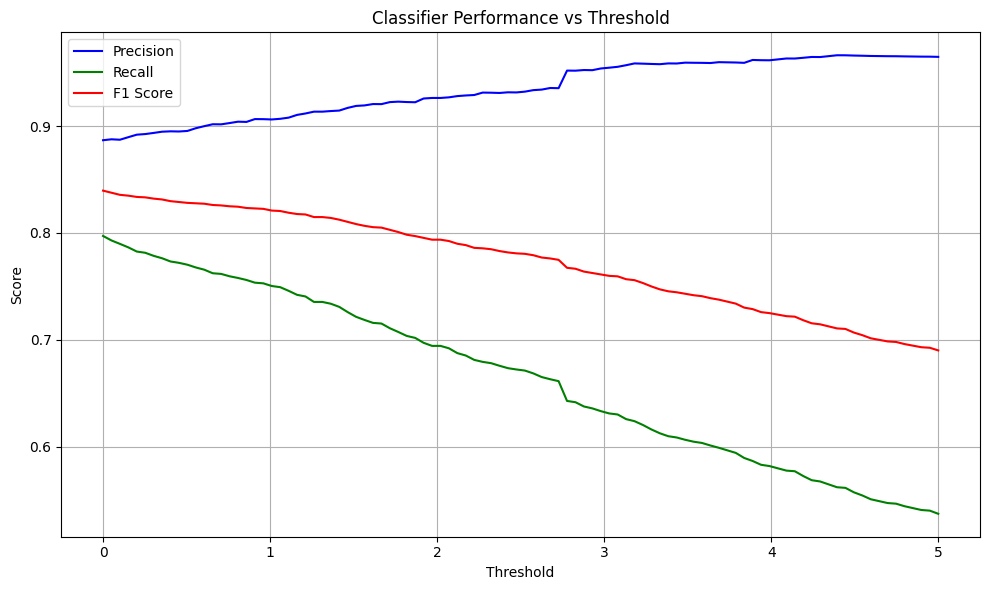

In [68]:
thresholds, precisions, recalls, f1_scores = evaluate_threshold_curve(player_scores_per_game)

In [69]:
with open("data/val_games_player_scores.pkl", "wb") as f:
    pickle.dump(player_scores_per_game, f)

In [70]:
def evaluate_thresholds_roc(player_scores_per_game, threshold_list):
    score_diffs = []
    labels = []

    for scores in player_scores_per_game:
        bot_score = scores["bot"]
        for player, human_score in scores.items():
            if player == "bot":
                continue
            score_diffs.append(bot_score - human_score)
            labels.append(1)

            score_diffs.append(human_score - bot_score)
            labels.append(0)

    score_diffs = np.array(score_diffs)
    labels = np.array(labels)

    fpr_base, tpr_base, _ = roc_curve(labels, score_diffs)
    roc_auc_base = auc(fpr_base, tpr_base)

    precision_base, recall_base, _ = precision_recall_curve(labels, score_diffs)
    pr_auc_base = auc(recall_base, precision_base)

    baseline_precision = np.mean(labels)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_base, tpr_base, label=f"Base ROC AUC = {roc_auc_base:.4f}", color="black", linestyle="--")
    plt.plot([0, 1], [0, 1], linestyle=":", color="gray", label="Random Classifier (Baseline)")

    for thresh in threshold_list:
        preds = (score_diffs >= thresh).astype(int)
        tp = np.sum((preds == 1) & (labels == 1))
        fp = np.sum((preds == 1) & (labels == 0))
        fn = np.sum((preds == 0) & (labels == 1))
        tn = np.sum((preds == 0) & (labels == 0))

        fpr = fp / (fp + tn) if (fp + tn) else 0
        tpr = tp / (tp + fn) if (tp + fn) else 0
        plt.scatter(fpr, tpr, label=f"Threshold {thresh:.2f}")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)



    plt.subplot(1, 2, 2)
    plt.plot(recall_base, precision_base, label=f"Base PR AUC = {pr_auc_base:.4f}", color="black", linestyle="--")
    plt.axhline(y=baseline_precision, color="gray", linestyle=":", label=f"Baseline Precision = {baseline_precision:.2f}")

    for thresh in threshold_list:
        preds = (score_diffs >= thresh).astype(int)
        tp = np.sum((preds == 1) & (labels == 1))
        fp = np.sum((preds == 1) & (labels == 0))
        fn = np.sum((preds == 0) & (labels == 1))

        precision = tp / (tp + fp) if (tp + fp) else 0
        recall = tp / (tp + fn) if (tp + fn) else 0
        plt.scatter(recall, precision, label=f"Threshold {thresh:.2f}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "base_roc_auc": roc_auc_base,
        "base_pr_auc": pr_auc_base,
        "baseline_precision": baseline_precision
    }


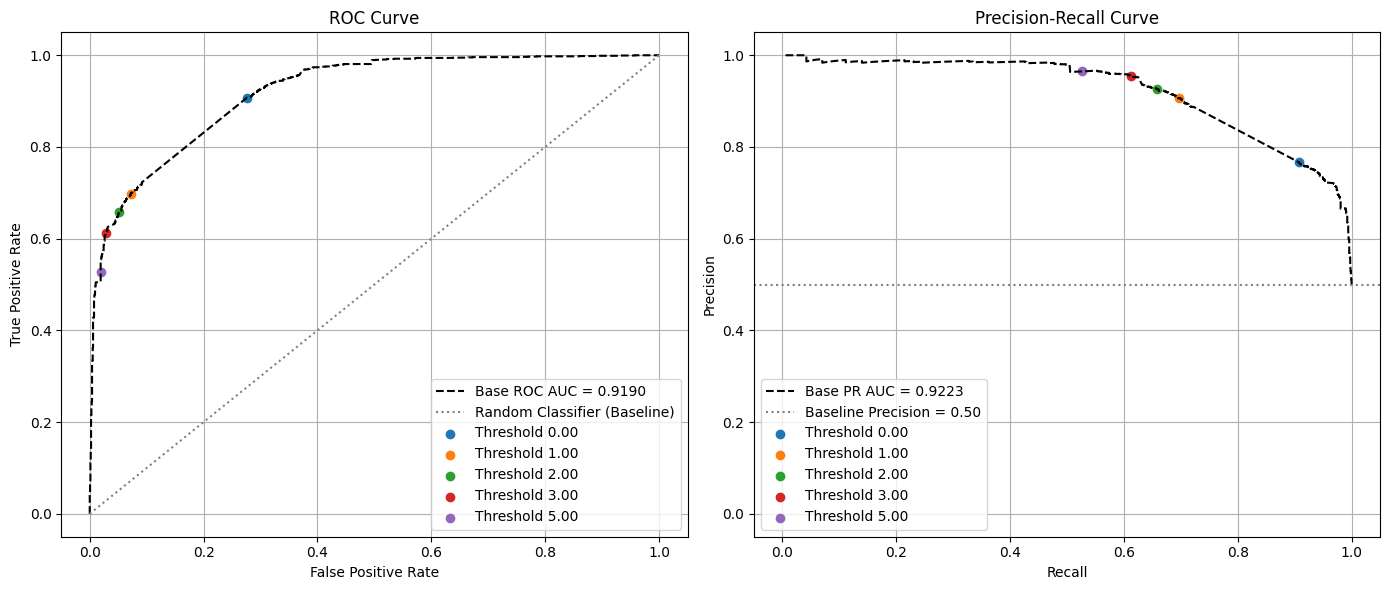

In [71]:
output = evaluate_thresholds_roc(player_scores_per_game, [0, 1, 2, 3, 5])

In [72]:
with open("data/false_game_ids_threshold_3.pkl", "rb") as f:
    wrong_indices = pickle.load(f)
    
val_games = game_ids

In [73]:
lengths = 0
long_wrong_games = []
for game in wrong_indices:
    game_messages = []
    game_data = chat_data[game]
    for message in game_data["messages"]:
        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                break
            else:
                continue
        game_messages.append(message["message"])
    lengths += len(game_messages)
    if len(game_messages) >= 10:
        long_wrong_games.append(game)

print(lengths/len(wrong_indices))

4.259370314842578


In [74]:
print(len(long_wrong_games))
print(len(wrong_indices))

64
667


In [75]:
print(wrong_indices)

[4051, 4051, 4052, 4052, 4053, 4053, 4054, 4054, 4055, 4055, 4059, 4064, 4066, 4067, 4069, 4069, 4082, 4082, 4085, 4085, 4086, 4086, 4087, 4090, 4090, 4094, 4094, 4096, 4096, 4097, 4097, 4099, 4099, 4100, 4103, 4104, 4112, 4114, 4116, 4120, 4120, 4121, 4121, 4127, 4141, 4148, 4149, 4151, 4151, 4152, 4152, 4153, 4153, 4154, 4154, 4155, 4155, 4156, 4157, 4157, 4158, 4158, 4159, 4159, 4162, 4162, 4164, 4164, 4168, 4168, 4170, 4170, 4171, 4171, 4176, 4176, 4178, 4178, 4180, 4181, 4187, 4187, 4192, 4192, 4198, 4204, 4208, 4209, 4211, 4211, 4214, 4214, 4215, 4216, 4221, 4223, 4223, 4224, 4224, 4233, 4233, 4237, 4237, 4239, 4239, 4241, 4242, 4243, 4244, 4244, 4246, 4250, 4253, 4255, 4256, 4258, 4258, 4259, 4260, 4260, 4261, 4262, 4263, 4266, 4266, 4271, 4271, 4273, 4274, 4275, 4275, 4278, 4284, 4289, 4289, 4291, 4299, 4299, 4300, 4300, 4304, 4305, 4305, 4310, 4313, 4316, 4316, 4319, 4320, 4320, 4322, 4324, 4324, 4325, 4326, 4328, 4330, 4330, 4331, 4331, 4334, 4337, 4337, 4339, 4339, 4341, 434

In [76]:
english = 0
german = 0
for idx in long_wrong_games:
    if chat_data[idx]["language"] == "de":
        german += 1
    if chat_data[idx]["language"] == "en":
        english += 1
print(german)
print(english)

10
53


In [77]:
with open("data/corresponding_game_ids.pkl", "rb") as f:
    tested_game_ids = pickle.load(f)

In [78]:
def evaluate_language_curves(player_scores_per_game):
    with open("data/corresponding_game_ids.pkl", "rb") as f:
        game_ids = pickle.load(f)
    with open("data/100925_data.pkl", "rb") as f:
        chat_data = pickle.load(f)

    def get_score_diffs(labels_filter=None):
        score_diffs = []
        labels = []
        for scores, game_id in zip(player_scores_per_game, game_ids):
            lang = chat_data[game_id]["language"]
            if labels_filter and lang not in labels_filter:
                continue

            bot_score = scores["bot"]
            for player, human_score in scores.items():
                if player == "bot":
                    continue
                score_diffs.append(bot_score - human_score)
                labels.append(1)
                score_diffs.append(human_score - bot_score)
                labels.append(0)
        return np.array(score_diffs), np.array(labels)

    plt.figure(figsize=(14, 6))

    # --- ROC Curve ---
    plt.subplot(1, 2, 1)
    for lang_label, langs in [("EN", ["en"]), ("DE", ["de"]), ("All", None)]:
        score_diffs, labels = get_score_diffs(labels_filter=langs)
        fpr, tpr, _ = roc_curve(labels, score_diffs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{lang_label} ROC AUC = {roc_auc:.4f}")

    plt.plot([0, 1], [0, 1], linestyle=":", color="gray", label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve by Language")
    plt.legend()
    plt.grid(True)

    # --- Precision-Recall Curve ---
    plt.subplot(1, 2, 2)
    for lang_label, langs in [("EN", ["en"]), ("DE", ["de"]), ("All", None)]:
        score_diffs, labels = get_score_diffs(labels_filter=langs)
        precision, recall, _ = precision_recall_curve(labels, score_diffs)
        pr_auc = auc(recall, precision)
        baseline_precision = np.mean(labels)
        plt.plot(recall, precision, label=f"{lang_label} PR AUC = {pr_auc:.4f}")
        plt.axhline(y=baseline_precision, color="gray", linestyle=":", alpha=0.5)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve by Language")
    plt.legend()
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


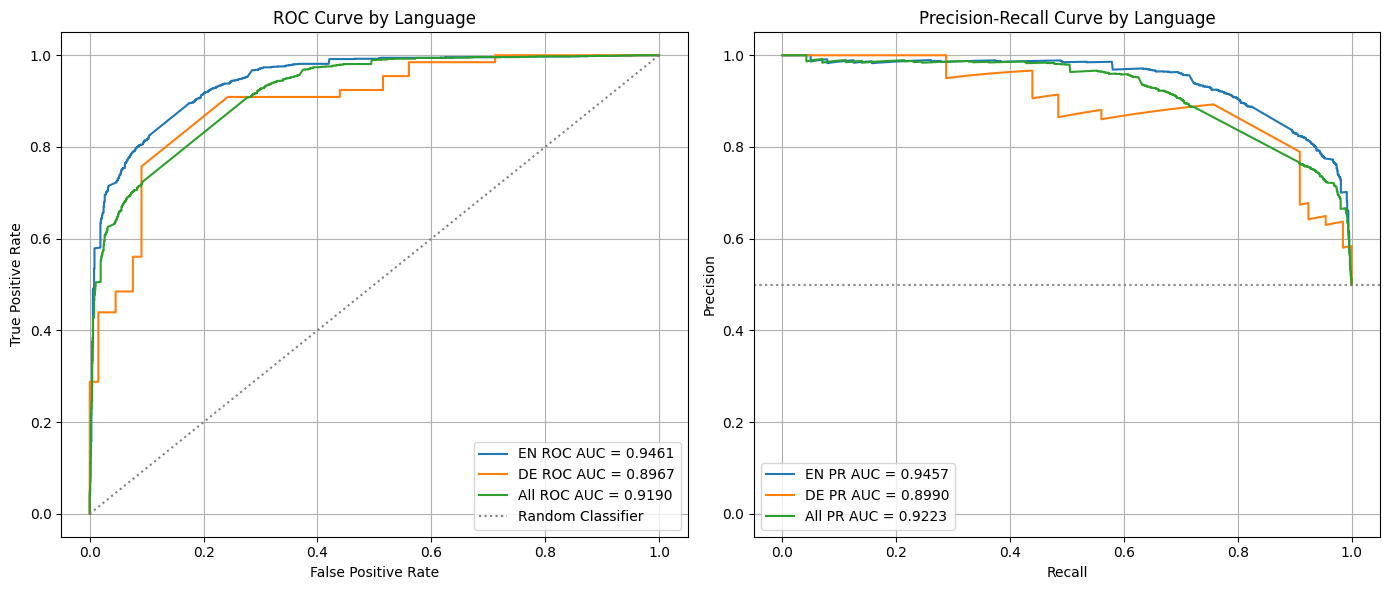

In [79]:
output = evaluate_language_curves(player_scores_per_game)